In [1]:
### import packages ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import time
from scipy.integrate import odeint
from scipy import linalg

In [2]:
### parameters ###
nbins = 10000
rmin  =  0.0
rmax  = 10.0
dr    =  (rmax-rmin)/float(nbins)
r = np.arange(rmin,rmax,dr)

In [3]:
### define right hand side "source" term S ###
rho = np.zeros(nbins)
rho[r<1] = 1.
RHS = 4*np.pi*dr*dr*rho

$V'(r)$ and $V''(r)$ should be calculate in their second order finite difference approximation.

$\partial_r V_i = \frac{V_{i+1}-V_{i-1}}{2\Delta r}$ and $\partial_r^2 V_i = \frac{V_{i+1}-2V_{i}+V_{i-1}}{(\Delta r)^2}$

$V''(r)+\frac{2}{r}V'(r)=4\pi \rho (r)$

By simplification,

$\frac{V_{i+1}-2V_{i}+V_{i-1}}{(\Delta r)^2}+\frac{2}{r_i} \frac{V_{i+1}-V_{i-1}}{2\Delta r}=4\pi \rho (r_i)$

$V_{i+1}-2V_{i}+V_{i-1}+\frac{\Delta r}{r_i}(V_{i+1}-V_{i-1}) = 4\pi (\Delta r)^2 \rho (r_i)$

$(1-\frac{\Delta r}{r_i})V_{i-1}-2V_{i}+(1+\frac{\Delta r}{r_i})V_{i+1} = 4\pi (\Delta r)^2 \rho (r_i)$

Apply Neuman boundary conditions at the origin.\
 ***You need to substitute the number for main equation due to the limitation of r to 0***

$\partial_r V = 0$ with respect to $r\rightarrow 0$, so $V_{-1} = V_{0}$

$\frac{V_{1}-2V_{0}+V_{-1}}{(\Delta r)^2} + 0=4\pi \rho (r_0)$

$-V_0 + V_1 = 4\pi (\Delta r)^2 \rho (r_0)$

Apply Robin conditions at the outer edge.

$\partial_r (rV) = 0$ with respect to $r\rightarrow r_n$, so $V_{n+1} = \frac{r_n}{r_{n+1}} V_{n}=\frac{r_n}{r_{n}+\Delta r} V_{n}$

$(1-\frac{\Delta r}{r_n})V_{n-1}-2V_{n}+\frac{\Delta r+ r_n}{r_n}V_{n+1} = 4\pi (\Delta r)^2 \rho (r_n)$

$(1-\frac{\Delta r}{r_n})V_{n-1}-V_{n} = 4\pi (\Delta r)^2 \rho (r_n)$

In [4]:
### define matrix A on left hand side ###
M = np.full((nbins, nbins), 0.0)  # define nbins x nbins matrix with components initialized to zero  
for i in range(nbins):
    if i == 0:
        M[0,0] = -1.
        M[0,1] = 1.
    elif i == nbins-1 :
        M[i,i-1] = 1.-dr/r[-1]
        M[i,i] = -1.
    else:
        M[i,i-1] = 1.-dr/r[i]
        M[i,i] = -2.
        M[i,i+1] = 1.+dr/r[i]
print('The Laplace Matrix A is:')
print(M)

The Laplace Matrix A is:
[[-1.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.         -2.          2.         ...  0.          0.
   0.        ]
 [ 0.          0.5        -2.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -2.          1.00010003
   0.        ]
 [ 0.          0.          0.         ...  0.99989998 -2.
   1.00010002]
 [ 0.          0.          0.         ...  0.          0.99989999
  -1.        ]]


In [5]:
### solve for f(x) ###
tstart = time.time()
V = linalg.solve(M,RHS)
tstop = time.time()
print("number of bins = ",nbins)
print("time to solve  = ",tstop-tstart,"seconds")

number of bins =  10000
time to solve  =  8.929836750030518 seconds


In [6]:
### check: should recover initial rho ###
c = M.dot(V)/dr/dr/4/np.pi ### check A*f=dx*dx*S
if(True):
    print('The error of the solution')
    print("c - rho:")
    print(c-rho)

The error of the solution
c - rho:
[-4.02022859e-12 -4.02022859e-12 -4.02022859e-12 ... -8.83487412e-12
 -8.83487412e-12  4.41743706e-12]


Analytical solution of this question:

$V(r) = \frac{2 \pi r^2}{3} - 2\pi$ with respect to $(0 < r \leq 1)$

$V(r) = -\frac{4 \pi}{3r}$ with respect to $(1 < r \leq 10)$

In [7]:
### The analytical answer ###
V_ana = np.append(2*np.pi*(r[r<=1])**2/3-2*np.pi,-4*np.pi/3/r[r>1])

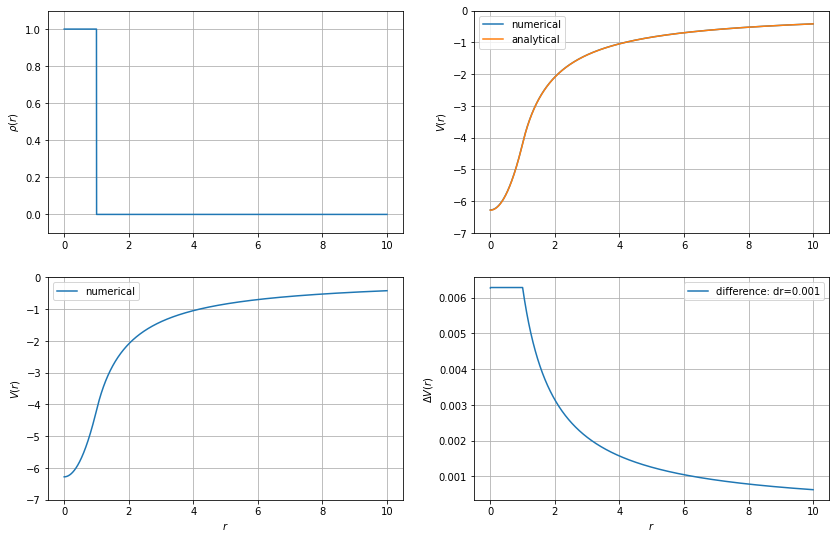

In [8]:
### plot the results ### 
    
fig,ax = plt.subplots(2,2,figsize=(14,9))

ax[0,0].plot(r,rho)
ax[0,0].set_ylabel(r"$\rho(r)$")
ax[0,0].set(xlim=[-.5,10.5],ylim=[-0.1,1.1])
ax[0,0].grid()

ax[1,0].plot(r,V,label='numerical')
ax[1,0].set_xlabel("$r$")
ax[1,0].set_ylabel("$V(r)$")
ax[1,0].set(xlim=[-.5,10.5],ylim=[-7,0])
ax[1,0].grid()
ax[1,0].legend()

ax[0,1].plot(r,V,label='numerical')
ax[0,1].plot(r,V_ana,label='analytical')
ax[0,1].set_ylabel("$V(r)$")
ax[0,1].set(xlim=[-.5,10.5],ylim=[-7,0])
ax[0,1].grid()
ax[0,1].legend()

ax[1,1].plot(r,V-V_ana,label='difference: dr=%.3f'%(dr))
ax[1,1].set_ylabel(r"$\Delta V(r)$")
ax[1,1].set_xlabel("$r$")
ax[1,1].set(xlim=[-.5,10.5])
ax[1,1].grid()
ax[1,1].legend()

plt.show()